# Navigation

---

The environment for this project is [Banana](https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation) from Unity, and it's provided in the `setup` folder. We'll implement the original [DQN algorithm](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) (but not directly from pixels) and two variations, [Double Q-Learning](https://arxiv.org/pdf/1509.06461.pdf) and [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf). Results will be compared in this notebook and the best solution will be implemented in `main.py`.

![final](imgs/gif_2.gif "final")

> The model used to generate this gif is `final.pth` (Dueling Double DQN), which was trained for 700 episodes using `main.py`.

## 1. Prepare dependencies and environment

Take a look at README.md before executing this notebook and make sure that the kernel is set to **p1_navigation**.

In [1]:
!pip -q install ./setup

import sys
import platform

import numpy as np
from numpy_ringbuffer import RingBuffer
from scipy import signal
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

from setup import unityagents
from unityagents import UnityEnvironment

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


Unity environments contain **brains**, our interfaces for controlling agents. We'll be conrtolling the first (default) brain in the environment. It's also useful to keep information such as `state_size` and `action_size`.

In [2]:
env = None
system = platform.system()
if system == 'Linux':
    env = UnityEnvironment(file_name="setup/Banana_Linux/Banana.x86_64")
elif system == 'Darwin':
    env = UnityEnvironment(file_name="setup/Banana.app")
elif system == 'Windows':
    env = UnityEnvironment(file_name="setup/Banana_Windows_x86_64/Banana.exe")
else:
    print('Cannot find environment for this system.')

# use the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 2. Experience replay

In a classical Q-Learning setting, the agent learns immediately from experiences, and then discards them. In DQN, instead, experiences are stored as tuples and learning is delayed and performed in sampled batches. Sampling is fundamental since it removes **correlations in the sequence of observations** and it also allows to learn from a more comprehensive set of tuples, promoting exploration and avoiding **feedback loops**.

We'll use the **uniform** variation of the replay buffer here, meaning that all stored tuples have the same chance of being selected for replay. The buffer has fixed `capacity` and will delete older tuples as newer ones arrive.

Every tuple is stored as `(s, a, r, ns, d)` where:

- `s` is the state at the beginning of the timestep
- `a` is the action that was taken
- `r` is the reward obtained in the next timestep
- `ns` is the state at the next timestep (we'll refer to this as $s'$ as well)
- `d` is a boolean value that determines if the episode ended

When sampling a batch of `n` tuples, we'll obtain a single tuple `([s], [a], [r], [ns], [d])` where:
- `[s]`, `[a]`, `[r]`, `[ns]`, `[d]` are **torch tensors** with `n` rows. Keep in mind that `[s]` and `[ns]` can have more than one column, depending on the `state_size`.

In [3]:
class UniformReplayBuffer():

    def __init__(self, capacity):
        self.capacity = capacity
        self.reset()
    
    def reset(self):
        self.buff = RingBuffer(capacity=self.capacity, dtype=object)
    
    def sample(self, n, replace=True):
        samples = np.random.choice(np.array(self.buff), n, replace)
        
        s = torch.FloatTensor([sample[0] for sample in samples]).to(device)
        a = torch.LongTensor([sample[1] for sample in samples]).to(device)
        r = torch.FloatTensor([sample[2] for sample in samples]).to(device)
        ns = torch.FloatTensor([sample[3] for sample in samples]).to(device)
        d = torch.FloatTensor([sample[4] for sample in samples]).to(device)
        
        return s, a, r, ns, d
    
    def add(self, observation):
        s, a, r, ns, d = observation
        self.buff.append((s, a, r, ns, d))
    
    def size(self):
        return len(self.buff)

## 3. Q Network

We have two choices for this network's architecture:

- `DQN`, the original Deep Q-Network
- `DuelingDQN`, the Dueling Deep Q-Network

Both models receive the current state $s$ as input and provide a vector for all estimated $Q(s, a)$ values at once. Since we're using PyTorch's autograd, we'll only define the architectures and the forward pass.

### 3.1 DQN

The `DQN` class is straightforward and uses less parameters, since it only uses one stream of fully connected layers:

- `state_size` $\to 64$ followed by `relu` activations
- $64 \to 128$ and `relu`
- $128 \to 64$ and `relu`
- $64 \to Q(s, a)$, that is $64 \to$ `action_size` and no activation

In [4]:
class DQN(nn.Module):
    
    def __init__(self, state_size, action_size, hidden_layers=[64, 128, 64]):
        super(DQN, self).__init__()
        
        # prepare the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])
        
        # prepare the output layer
        self.output_layer = nn.Linear(hidden_layers[-1], action_size)

    def forward(self, state):
        # connect layers to each other and put relu activations between them
        for layer in self.hidden_layers:
            state = layer(state)
            state = F.relu(state)
        state = self.output_layer(state)
        return state

### 3.2 DuelingDQN

On the other hand, `DuelingDQN` has two streams of independent layers: the **value** of a state $V(s)$ (scalar) and the **advantage** of taking an action $A(s, a)$ (same shape as the output), related by $A(s, a) = Q(s, a) - V(s)$. The idea is that, in many scenarios, the value of a state won't depend that much on the action the agent takes, so decoupling these values can help make better estimates.

Thus, the class `DuelingDQN` uses two identical streams of independent fully connected layers:

- `state_size` $\to 32$ and `relu`
- $32 \to 128$ and `relu`
- $128 \to 32$ and `relu`

The streams end in:

- $32 \to A(s, a)$, that is $32 \to$ `action_size` and no activation
- $32 \to V(s)$, that is $32 \to 1$ and no activation

To merge them, however, we can't simply add $V$ and $A$ as $Q(s, a) = V(s) + A(s, a)$, because $A$ and $V$ **won't be identifiable**. We can, instead, write

$$Q(s, a) = V(s) + A(s, a) - \max_{a'} A(S, a')$$

so that when the best action $a^*$ is selected, we get that $Q(s, a^*) = V(s)$, something that is not guaranteed otherwise. To further improve this, we can substitute the $\max$ operator for a mean of the available actions. This is the final equation used in the `DuelingDQN` class, where $|\mathbb{A}(s)| =$ `action_size`.

$$Q(s, a) = V(s) + A(s, a) - \frac{1}{|\mathbb{A}(s)|} \sum_{a' \in \mathbb{A}(s)} A(s, a')$$

In [5]:
class DuelingDQN(nn.Module):

    def __init__(self, state_size, action_size, hidden_layers=[32, 128, 32]):
        super(DuelingDQN, self).__init__()
        
        # prepare the first pair of hidden layers (will be two independent streams)
        self.value_hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        self.advantage_hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.value_hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])
        self.advantage_hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])
        
        # prepare the output layers for the streams, which will be merged in the forward operation
        self.value_output_layer = nn.Linear(hidden_layers[-1], 1)
        self.advantage_output_layer = nn.Linear(hidden_layers[-1], action_size)

    def forward(self, x):
        # the two streams receive the same input data x
        V = x
        A = x.clone()

        # as before, connect layers to each other and put relu activations between them
        for value_layer, advantage_layer in zip(self.value_hidden_layers, self.advantage_hidden_layers):
            V, A = value_layer(V), advantage_layer(A)
            V, A = F.relu(V), F.relu(A)
        V, A = self.value_output_layer(V), self.advantage_output_layer(A)

        # the output of the network is the special merging layer described in the dueling dqn paper
        return V + A - torch.mean(A, dim=1).unsqueeze(1)

## 4. Temporal-Difference error estimation

When we're calculating the **temporal-difference** error $\delta_t$ we have to rely on an estimate of future returns. Two proposed variants for this are fixed Q-targets and Double DQN.

The functions `dt_dqn`, `dt_double_dqn` implement the two variants. Both take an extra boolean parameter `d` that signals when the episode is over, since in that case, there is no future return and the TD error is simply $\delta_t = r - Q(s, a)$.

Note that these functions expect `s`, `a`, `r`, `ns` and `d` as **torch tensors**, where the number of rows corresponds to the batch size. The return value is also a vector with the same number of rows, one for each tuple.

#### 4.1 Fixed Q-targets

Due to the nature of neural networks (and function approximators in general), if we were to use the same Q network for both $Q(s, a)$ and $Q(s', a')$, a gradient descent step that is meant to improve the former would modify the latter as well, making learning unstable. Because of this – and also because we want to preserve mathematical correctness in the derivative – we use two different networks, $Q_{local}$ and $Q_{target}$.

This method is called fixed Q-targets, and it essentially **duplicates the network**, using $Q_{local}$ to determine the policy and $Q_{target}$ to estimate future returns. The latter is updated less frequently by copying (or interpolating towards) the parameters of the former, so that they're different enough to avoid instability. The equation for $\delta_t$ is

$$\delta_t(s, a, r, s') = r + \gamma \max_{a'} Q_{target}(s', a') - Q_{local}(s, a)$$

In [6]:
def dt_dqn(s, a, r, ns, d, q_local, q_target, gamma):
    with torch.no_grad():   # no need for gradients when we're evaluating the TD target
        QT = q_target(ns)   # evaluate the next state using the target network (out: [n * action_size])
        QT = QT.max(1)      # take the max along the column (actions) (out: two tensors [n])
        QT = QT[0]          # - [0] has the max values for each element in the batch, 
                            # - [1] has the indexes of the max values

    a = a.unsqueeze(1)      # reshape [n] -> [n * 1]
    QL = q_local(s)         # evaluate the current state using the local network (out: [n * action_size])
    QL = QL.gather(1, a)    # for each row, take the column in QL indicated by a (out: [n * 1])
    QL = QL.squeeze(1)      # reshape [n * 1] -> [n]
    
    return r + gamma * QT * (1 - d) - QL

### 4.2 Double DQN

This is largely based on fixed Q-targets, since it also uses $Q_{local}$ and $Q_{target}$. We can rewrite $\max Q$ using $\arg \max$ to break down the task of **choosing** and **evaluating** an action in two different steps.

$$\max_{a'} Q_{target}(s', a') = Q_{target}(s', \arg \max_{a'} Q_{target}(s', a'))$$

This can lead to the **overestimation** of targets. Simply put, when taking the $\max$ among noisy numbers (which is especially true in the beginning) we're likely to pick the action where the approximator adds more positive noise. Separating the task of picking and evaluating the action to two different approximators may decrease this issue, since both networks now have to "agree" on the outcome of an action.

The original estimate can be improved using the one provided in the Double DQN paper. The proposed solution is to use $Q_{local}$ for the choice and $Q_{target}$ for the evaluation as follows

$$
Q_{target}(s', \arg \max_{a'} Q_{local}(s', a'))\\
\implies \delta_t(s, a, r, s') = r + \gamma Q_{target}(s', \arg \max_{a'} Q_{local}(s', a')) - Q_{local}(s, a)
$$

In [7]:
def dt_double_dqn(s, a, r, ns, d, q_local, q_target, gamma):
    with torch.no_grad():         # no need for gradients when we're evaluating the TD target
        QLns = q_local(ns)        # evaluate the next state using the local network (out: [n * action_size])
        QLns = QLns.max(1)        # take the max along the column (actions) (out: two tensors [n])
        QLns = QLns[1]            # [1] has the indexes of the max values
        QLns = QLns.unsqueeze(1)  # reshape [n] -> [n * 1]

        QT = q_target(ns)         # evaluate the next state using the target network (out: [n * action_size])
        QT = QT.gather(1, QLns)   # for each row, take the value estimated by the target network for
                                  # the best action estimated by the local network (out: [n * 1])
        QT = QT.squeeze(1)        # reshape [n * 1] -> [n]

    a = a.unsqueeze(1)            # reshape [n] -> [n * 1]
    QL = q_local(s)               # evaluate the current state using the local network (out: [n * action_size])
    QL = QL.gather(1, a)          # for each row, take the column in QL indicated by a (out: [n * 1])
    QL = QL.squeeze(1)            # reshape [n * 1] -> [n]

    return r + gamma * QT * (1 - d) - QL

## 5. Agent

Let's put the pieces together. During initialization, we can configure the agent's:

- `QNetwork`, which is either the class `DQN` or `DuelingDQN` (_not an instance_)
- `replay_buffer`, which is an instance of `UniformReplayBuffer`
- `Delta`, which is either the function `dt_dqn` or `dt_double_dqn`

Other parameters are obviously `state_size` and `action_size` as well as some hyperparameters:

- `alpha` $\in [0, 1]$, the learning rate to apply to gradient steps to `q_local`
- `eps`, `eps_decay` and `min_eps` $\in [0, 1]$, for the $\epsilon$-greedy policy, if `learning = False` only the greedy policy will be used
- `gamma` $\in [0, 1]$, the weight of the estimates for future returns calculated by `q_target` in the function `Delta`
- `tau` $\in [0, 1]$, to perform soft updates of `q_target` (if set to $1$ directly copies `q_local` into `q_target`)
- `update_every` the number of steps to wait before updating `q_local` and `q_target`
- `batch_size` the number of samples from the `replay_buffer` used to perform one update of `q_local`

The agent has three functions, but only the first two should be called from the outside: 
- `act`, based on a state tensor `s` and on `eps`, choose an action. If the agent has `learning = False` the choice will be greedy.
- `store`, receive a tuple to put in the `replay_buffer`. This counts as a step towards the updates of `q_local` and `q_target`, and in fact calls `learn()` automatically when needed.
- `learn`, samples a batch of tuples from the `replay_buffer`, calculates their $\delta_t$ and finally performs gradient descent on `q_local` and a soft update of `q_target` towards `q_local`. Note that it can already perform actions related to a tuple's priority and importance sampling weight.

Additionally, an agent can be `reset()`.

In [8]:
class QNetworkAgent():
    
    # -- initialization -- #
    def __init__(self, QNetwork, state_size, action_size, 
                 replay_buffer, Delta, 
                 eps=1, eps_decay=0.9995, min_eps=0.0001,
                 gamma=0.99, alpha=0.001, tau=0.01,
                 update_every=15, batch_size=64, learning=True):
        self.state_size, self.action_size = state_size, action_size
        self.original_eps = eps
        self.QNetwork = QNetwork
        self.replay_buffer = replay_buffer
        self.Delta = Delta
        self.learning = learning
        self.eps, self.eps_decay, self.min_eps = eps, eps_decay, min_eps
        self.gamma, self.alpha, self.tau = gamma, alpha, tau
        self.update_every, self.batch_size = update_every, batch_size
        self.reset()
    
    def reset(self):
        self.replay_buffer.reset()
        self.eps = self.original_eps
        self.q_local = self.QNetwork(self.state_size, self.action_size).to(device)
        self.q_target = self.QNetwork(self.state_size, self.action_size).to(device)
        self.optimizer = optim.Adam(self.q_local.parameters(), lr=self.alpha)
        self.update_i = 0
    # -- initialization -- #

    def act(self, s):

        # eps-greedy policy: decide if the action should be random or greedy
        # (always greedy if agent.learning = False)
        if not self.learning or np.random.uniform() > self.eps:
            # greedy action, no need for autograd in this step. simply estimate
            # Q values for this state and return the action with the highest value
            with torch.no_grad():
                s = torch.FloatTensor(s).unsqueeze(0).to(device)
                return int(self.q_local(s).max(1)[1])
        else:
            # choose uniformly between all actions
            return np.random.randint(self.action_size)
    
    def store(self, s, a, r, ns, d):
        # store a new experience
        self.replay_buffer.add((s, a, r, ns, d))

        if self.update_i == 0 and self.replay_buffer.size() >= self.batch_size:
            # after you've stored enough new experiences update q_local and q_target
            # (note however that the batch used to learn might not contain the new experiences)
            self.learn()

            # also decrease epsilon
            self.eps = max(self.eps * self.eps_decay, self.min_eps)
        
        # keep track of how many new experiences we get
        self.update_i = (self.update_i + 1) % self.update_every
    
    def learn(self):
        # note that this is called automatically by the agent

        # sample tuples of experiences from memory (each of these variables is a torch tensor)
        s, a, r, ns, d = self.replay_buffer.sample(self.batch_size)

        # use the given function to calculate the difference between the TD target and our estimate
        td_delta = self.Delta(s, a, r, ns, d, self.q_local, self.q_target, self.gamma)
        
        # use autograd to backpropagate, the error is MSE on td_delta
        self.optimizer.zero_grad()
        loss = torch.mean(td_delta ** 2)
        loss.backward()
        self.optimizer.step()
        
        # after updating q_local we also update q_target. the original paper makes a copy of the parameters,
        # however we can perform a 'soft' update by interpolating between the current parameters and the new ones
        with torch.no_grad():
            for local, target in zip(self.q_local.parameters(), self.q_target.parameters()):
                target.copy_(target + self.tau * (local - target))

Creating an agent is straightforward now. We can make four agents, one for each combination of things that we've defined earlier. Note that these agents share the same default hyperparameters that were chosen after some tests:

- `eps=1`, `eps_decay=0.9995`, `min_eps=0.0001`,
- `gamma=0.99`
- `alpha=0.001`
- `tau=0.01`
- `update_every=15`
- `batch_size=64`

In [9]:
agents = [('DQN', QNetworkAgent(DQN, state_size, action_size, UniformReplayBuffer(100_000), dt_dqn)),
          ('Double DQN', QNetworkAgent(DQN, state_size, action_size, UniformReplayBuffer(100_000), dt_double_dqn)),
          ('Dueling DQN', QNetworkAgent(DuelingDQN, state_size, action_size, UniformReplayBuffer(100_000), dt_dqn)),
          ('Dueling Double DQN', QNetworkAgent(DuelingDQN, state_size, action_size, UniformReplayBuffer(100_000), dt_double_dqn))]

## 6. Training an agent

What we define now is a function that connects our `agent` and `env`. Recall that we'll be using the default `brain_name` to interact with the environment. The agent is allowed to store observations and, consequently, learn every now and then (`update_every=15` steps).

In [10]:
def execute_episode(agent, env):
    # prepare the environment
    score = 0
    done = False
    env_info = env.reset(train_mode=True)[brain_name]
    
    # get the initial state
    state = env_info.vector_observations[0]
    while not done:

        # evaluate the current state
        action = agent.act(state)

        # execute the chosen action and get the outcome
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]

        # store the experience (also automatically learn, from time to time)
        agent.store(state, action, reward, next_state, done)

        # prepare for the next iteration
        state = next_state
        score += reward
    
    # return the total rewards obtained
    return score

We can call the function above repeatedly while **monitoring** what happens, so that we'll be able to compare different approaches. The most important indicator is going to be the average score over 100 consecutive episodes: the environment is considered **solved when the agent scores +13 or more** under this metric. We'll be training each agent 3 times from scratch, for 1000 episodes, and we'll average the results. This way, the learning curves will depend less on the randomness of the environment, reflecting more accurately the differences in the approaches.

In [11]:
def train(agent, env, episodes=1000, repeat=3, consecutive_episodes=100, show_output=True, save_as=None):

    results = [None] * repeat
    for r in range(repeat):
        partial_results = [None] * episodes

        # reset the agent to start learning from scratch
        agent.reset()
        for i in range(episodes):

            # execute all the episodes and store the results
            score = execute_episode(agent, env)
            partial_results[i] = score
            
            if show_output:
                print("\r[{}] Episode: {}, Score: {}".format(r+1, i+1, score), end="")
                sys.stdout.flush()
        if show_output:
            print()

        results[r] = partial_results

        # store the trained model if requested
        if save_as is not None:
            torch.save(agent.q_local.state_dict(), '{}/{}.pth'.format(save_as, r+1))

    # use convolutions to calculate the mean and standard deviation summarizing the training step
    results = np.array(results)
    mean = signal.convolve2d(results, np.ones([repeat, consecutive_episodes]) / (repeat * consecutive_episodes), mode='valid')    
    v = signal.convolve2d(results, np.ones([1, consecutive_episodes]) / consecutive_episodes, mode='valid')
    std_dev = signal.convolve2d(v ** 2 - mean ** 2, np.ones([repeat, 1]) / repeat, mode='valid') ** (1/2)
    return mean.flatten(), std_dev.flatten(), results

In [12]:
training_results = []
for ag in agents:
    name, agent = ag
    print('Agent: {}'.format(name))
    mean, std_dev, full_report = train(agent, env, save_as='models/{}'.format(name.replace(" ", "_")))
    training_results.append((mean, std_dev, full_report))
env.close()

Agent: DQN
[1] Episode: 1000, Score: 6.0
[2] Episode: 1000, Score: 18.0
[3] Episode: 1000, Score: 9.0
Agent: Double DQN
[1] Episode: 1000, Score: 12.0
[2] Episode: 1000, Score: 19.0
[3] Episode: 1000, Score: 18.0
Agent: Dueling DQN
[1] Episode: 1000, Score: 11.0
[2] Episode: 1000, Score: 15.0
[3] Episode: 1000, Score: 14.0
Agent: Dueling Double DQN
[1] Episode: 1000, Score: 19.0
[2] Episode: 1000, Score: 15.0
[3] Episode: 1000, Score: 15.0


## 7. Comparing the results

We can use `matplotlib` to plot the mean of the score and its standard deviation. Clearly all algorithms proposed manage to score an average of 13 points or more on 100 consecutive runs, thus solving the environment, and they do so in about 400 episodes. Double DQN and Dueling DQN allow for slightly better performances and faster convergence, especially when combined. We can also see that there's not much progress after 700 episodes, suggesting that there's no need to keep training for longer.

DQN: Solved after 420 episodes
Double DQN: Solved after 414 episodes


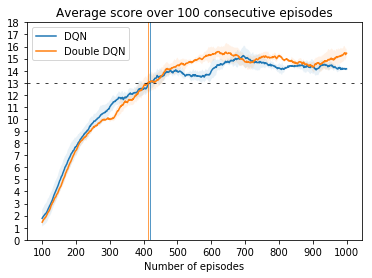

Dueling DQN: Solved after 413 episodes
Dueling Double DQN: Solved after 385 episodes


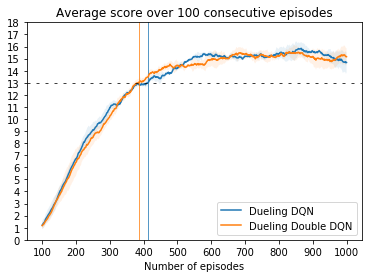

In [13]:
def plot_results(agents, training_results):
    for agent, ts in zip(agents, training_results):
        mean, std_dev, _ = ts
        episode_solved = np.argmax(mean > 13) + 100
        print('{}: Solved after {} episodes'.format(agent[0], episode_solved))

        x = np.arange(100, 100 + mean.size)
        line = plt.plot(x, mean, label = agent[0])
        plt.fill_between(x, mean + std_dev, mean - std_dev, alpha=0.1)
        plt.axvline(episode_solved, lw=0.75, color=line[0].get_color())

    plt.axhline(13, dashes=(4, 8), lw=0.75, color='black')
    plt.xticks(np.arange(1, 1 + mean.size / 100) * 100)
    plt.yticks(np.arange(0, 19))
    plt.xlabel('Number of episodes')
    plt.title('Average score over 100 consecutive episodes')
    plt.legend()
    plt.show()

plot_results(agents[:2], training_results[:2])
plot_results(agents[2:], training_results[2:])

## 8. Possible improvements

By observing any of the above agents play we can see that sometimes this happens.

![stuck](imgs/gif_1.gif "stuck")

One of the reasons for this might be that the states are completely independent from each other. Although the original DQN paper worked directly on pixels, to overcome this issue they provided **four consecutive frames** to the agent, instead of one. This only requires slight modifications to the code, for instance we need to change the input of the network to `4 * state_size` and update the function `execute_episode` to handle four states instead of one, as follows:

In [15]:
def execute_episode_v2(agent, env):
    score = 0
    done = False
    env_info = env.reset(train_mode=True)[brain_name]

    state = env_info.vector_observations[0]
    consecutive_states = [state] * 4                       # replicate the first state four times
    edited_state = np.array(consecutive_states).flatten()  # merge four states into one vector

    while not done:
        action = agent.act(edited_state)

        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]

        consecutive_states.pop(0)                                   # remove the oldest state
        consecutive_states.append(next_state)                       # and add the newest one
        edited_next_state = np.array(consecutive_states).flatten()  # then merge again

        agent.store(edited_state, action, reward, edited_next_state, done)
        edited_state = edited_next_state
        score += reward

    return score

Another important improvement could be the use of a **prioritized replay buffer**. This can be implemented by creating a class based on `UniformReplayBuffer` which uses a sum tree instead of a ring buffer, and adding two functions `max_priority` and `update_priority`. We'll also need to modify `add` and `sample` to handle priorities as well.

When storing a tuple `(s, a, r, ns, d, p)` the parameter `p` will be the **priority** of the tuple, with $p = |\delta_t|$. When sampling a batch of `n` tuples, we'll obtain a single tuple `([s], [a], [r], [ns], [d], [w])` where `[w]` is the `n`-rows tensor of **importance sampling weights**, with a single $w = a \left({1 \over N} {1 \over P(i)}\right)^b {1 \over \max_i w_i}$, $a, b \in [0, 1]$. The $i$-th tuple will be sampled based on $P(i) = \frac{p_i^a}{\sum_k o_k^a}$, where $p_i$ is the tuple's priority. Note that there's no need to provide the priority to the agent.

The code in the agent would then need to be modified as follows:

In [ ]:
def store(self, s, a, r, ns, d):
    p = self.replay_buffer.max_priority()  # store every new tuple with max priority
    self.replay_buffer.add((s, a, r, ns, d, p))
    # ...

def learn(self):
    s, a, r, ns, d, w = self.replay_buffer.sample(self.batch_size)                # now also returns tensor w
    # ...
    self.replay_buffer.update_priority(zip(s, a, r, ns, d, torch.abs(td_delta)))  # update priorities as |td_delta|
    # ...        
    loss = torch.sum(w * (td_delta ** 2))                                         # weighted MSE

## 9. Conclusions

Although there are many more improvements that could be applied (see [Rainbow](https://arxiv.org/pdf/1710.02298.pdf)), the agents manage to play well most of the time. The models used to create the graphs in section 7 are available in the repository. The full documented code is also available and `main.py` can be executed to train or load a pre-trained Dueling Double DQN agent and see it in action, just like we did for thr model `final.pht`.